Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 60, 68, 68, 3)]      0         []                            
                                                                                                  
 time_distributed (TimeDist  (None, 60, 66, 66, 32)       896       ['input_1[0][0]']             
 ributed)                                                                                         
                                                                                                  
 time_distributed_1 (TimeDi  (None, 60, 33, 33, 32)       0         ['time_distributed[0][0]']    
 stributed)                                                                                       
                                                                                              

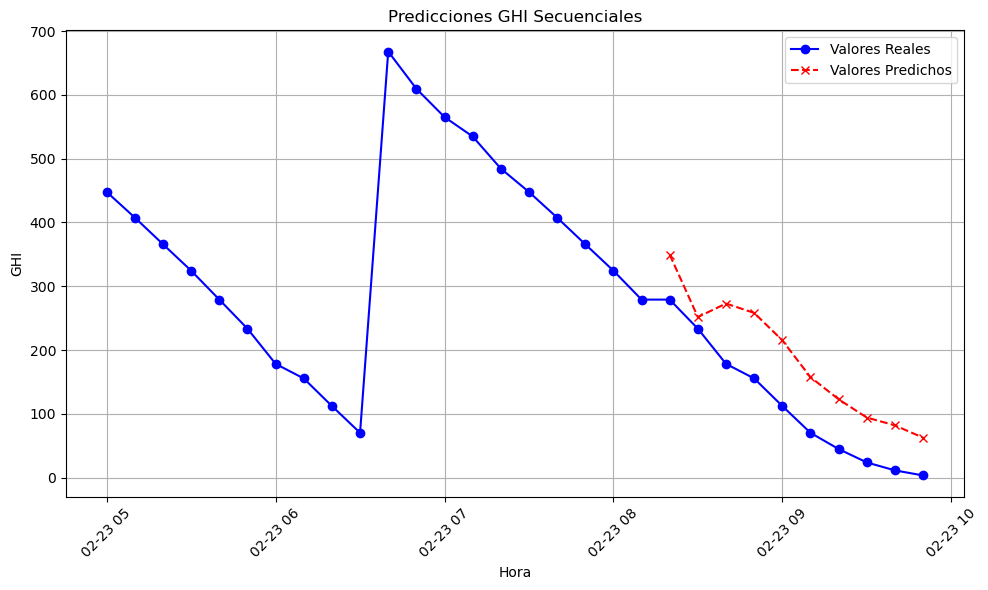

In [1]:
import pandas as pd
import cv2
import numpy as np
from datetime import datetime
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, LSTM, TimeDistributed, Concatenate, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

df = pd.read_pickle('df_GHI.plk')

# Función para convertir el formato de timestamp del DataFrame al formato de los nombres de las imágenes
def timestamp_to_image_name(timestamp):
    return 'ACMF_' + timestamp.strftime('%Y%m%d_%H%M%S') + '.jpg'

# Asegúrate de que la columna 'Timestamp' sea de tipo datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Filtrar el DataFrame por el rango de tiempo
fecha_inicio = '2022-02-23 05:00:00'
fecha_fin = '2022-02-23 18:20:00'
df_filtrado = df[(df['Timestamp'] >= fecha_inicio) & (df['Timestamp'] <= fecha_fin)]

# Cargar imágenes y valores GHI normalizados, con imágenes redimensionadas a 68x68
def load_images_and_ghi(df_filtrado, image_folder):
    images = []
    ghi_values = []
    
    for idx, row in df_filtrado.iterrows():
        timestamp = row['Timestamp']
        ghi_value = row['GHI']
        image_name = timestamp_to_image_name(timestamp)
        image_path = f'{image_folder}/{image_name}'
        img = cv2.imread(image_path)
        
        if img is not None:
            # Redimensionar la imagen a 68x68 píxeles y normalizar dividiendo por 255
            img_resized = cv2.resize(img, (68, 68)) / 255.0
            images.append(img_resized)
            ghi_values.append(ghi_value)
        else:
            print(f"Imagen no encontrada: {image_path}")
    
    # Normalizar los valores GHI
    ghi_values = np.array(ghi_values).reshape(-1, 1)
    scaler = MinMaxScaler()
    ghi_values_scaled = scaler.fit_transform(ghi_values)
    
    return np.array(images), ghi_values_scaled, scaler

# Cargar imágenes y valores GHI
image_folder = 'Images/ACMF'
X_images, y_ghi, scaler = load_images_and_ghi(df_filtrado, image_folder)

# Crear secuencias de entrada y salida
def create_sequences(X_images, y_ghi, seq_len, num_pred):
    X_seq_images = []
    X_seq_ghi = []
    y_seq_ghi = []

    for i in range(len(X_images) - seq_len - num_pred):
        X_seq_images.append(X_images[i:i+seq_len])  # Secuencia de imágenes
        X_seq_ghi.append(y_ghi[i:i+seq_len])        # Secuencia de valores GHI
        y_seq_ghi.append(y_ghi[i+seq_len:i+seq_len+num_pred])  # Valores a predecir

    return np.array(X_seq_images), np.array(X_seq_ghi), np.array(y_seq_ghi)

# Parámetros del modelo
seq_len = 60  # Longitud de la secuencia de entrada
num_pred = 10  # Número de valores a predecir
X_images_seq, X_ghi_seq, y_ghi_pred = create_sequences(X_images, y_ghi, seq_len, num_pred)

# Dividir los datos en conjunto de entrenamiento y prueba
X_images_seq_train, X_images_seq_test, X_ghi_seq_train, X_ghi_seq_test, y_ghi_pred_train, y_ghi_pred_test = train_test_split(
    X_images_seq, X_ghi_seq, y_ghi_pred, test_size=0.2, random_state=42
)

# Definir el modelo CNN-LSTM ajustado para imágenes de 68x68 píxeles
img_shape = (68, 68, 3)

image_input = Input(shape=(seq_len, *img_shape))
cnn_model = TimeDistributed(Conv2D(32, (3, 3), activation='relu'))(image_input)
cnn_model = TimeDistributed(MaxPooling2D((2, 2)))(cnn_model)
cnn_model = TimeDistributed(Conv2D(64, (3, 3), activation='relu'))(cnn_model)
cnn_model = TimeDistributed(MaxPooling2D((2, 2)))(cnn_model)
cnn_model = TimeDistributed(Conv2D(128, (3, 3), activation='relu'))(cnn_model)
cnn_model = TimeDistributed(MaxPooling2D((2, 2)))(cnn_model)
cnn_model = TimeDistributed(Flatten())(cnn_model)

# Agregar una capa Dropout para prevenir sobreajuste
cnn_model = Dropout(0.3)(cnn_model)

numeric_input = Input(shape=(seq_len, 1))
concat = Concatenate()([cnn_model, numeric_input])

lstm_out = LSTM(64, return_sequences=False)(concat)

# Capa Dropout adicional para regularización
lstm_out = Dropout(0.3)(lstm_out)

output = Dense(num_pred)(lstm_out)

# Definir el modelo
model = Model([image_input, numeric_input], output)

# Compilar el modelo con un learning rate más bajo
model.compile(optimizer='adam', loss='mse')

# Resumen del modelo
model.summary()

# Entrenar el modelo con el conjunto de entrenamiento
history = model.fit([X_images_seq_train, X_ghi_seq_train], y_ghi_pred_train, epochs=100, batch_size=32, validation_split=0.2)

# Predicción secuencial, avanzando en el tiempo
y_ghi_pred_test_sequential = []

# Asegurarse de que las secuencias de entrada estén correctamente avanzadas en el tiempo
for i in range(10):
    # Hacer una predicción usando la secuencia completa de 60 imágenes
    pred = model.predict([X_images_seq_test, X_ghi_seq_test])  # Predecir para la secuencia actual de 60 imágenes
    y_ghi_pred_test_sequential.append(pred.flatten())  # Almacenar la predicción
    
    # Avanzar en el tiempo actualizando los datos de entrada (desplazar 1 paso hacia adelante)
    X_images_seq_test = np.roll(X_images_seq_test, -1, axis=1)  # Desplazar la secuencia de imágenes hacia adelante
    X_ghi_seq_test = np.roll(X_ghi_seq_test, -1, axis=1)  # Desplazar la secuencia de GHI hacia adelante

# Convertir las predicciones secuenciales a un array
y_ghi_pred_test_sequential = np.concatenate(y_ghi_pred_test_sequential)

# Invertir la normalización de los valores predichos
y_ghi_pred_test_inversed = scaler.inverse_transform(y_ghi_pred_test_sequential.reshape(-1, 1)).flatten()

# Invertir la normalización de los valores reales para la prueba
y_ghi_test_inversed = scaler.inverse_transform(y_ghi_pred_test.reshape(-1, 1)).flatten()

# Generar una serie de timestamps para el eje x (con 10 minutos de diferencia)
timestamps = pd.date_range(start='2022-02-23 05:00:00', periods=len(y_ghi_test_inversed), freq='10T')

# Función ajustada para graficar los valores reales y predichos de forma secuencial
def plot_real_vs_predicted(y_true, y_pred, timestamps, title="GHI: Predicciones vs Reales"):
    plt.figure(figsize=(10, 6))

    # Graficar los valores reales para todo el intervalo
    plt.plot(timestamps, y_true, label="Valores Reales", color='blue', marker='o')

    # Graficar los valores predichos de forma secuencial
    plt.plot(timestamps[-10:], y_pred, label="Valores Predichos", color='red', linestyle='--', marker='x')

    # Configuración del gráfico
    plt.title(title)
    plt.xlabel("Hora")
    plt.ylabel("GHI")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()

# Graficar los resultados reales y predichos secuenciales
plot_real_vs_predicted(y_ghi_test_inversed, y_ghi_pred_test_inversed[-10:], timestamps, title="Predicciones GHI Secuenciales")
